In [ ]:
print("Stonks stonks stonks")

Stonks stonks stonks


In [ ]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
stock_symbol = 'TATASTEEL.NS'
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')


[*********************100%***********************]  1 of 1 completed


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-27,62.880619,62.880619,61.265728,61.865952,25.103474,52058583
2017-09-28,62.204174,62.547161,61.227619,61.899300,25.117006,69053825
2017-09-29,62.385197,62.594795,61.932644,62.170830,25.227186,29796912
2017-10-03,62.547161,63.442734,62.547161,62.956837,25.546127,29913418
2017-10-04,62.918728,63.123566,62.351849,62.785343,25.476542,29226912


In [ ]:
len(data)

1236

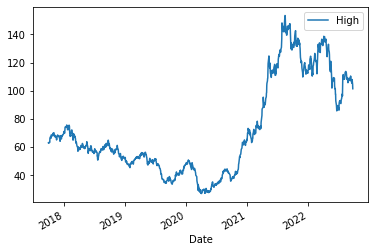

In [ ]:
opn = data[['High']]
opn.plot()

In [ ]:
import matplotlib.pyplot as plt
ds = opn.values
ds

array([[ 62.88061905],
       [ 62.5471611 ],
       [ 62.59479523],
       ...,
       [107.90000153],
       [104.44999695],
       [101.34999847]])

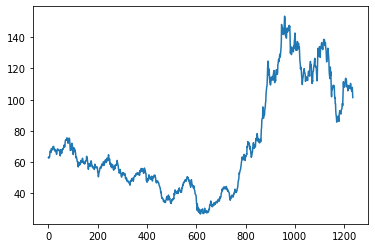

In [ ]:
plt.plot(ds)


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [ ]:

#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
len(ds_scaled), len(ds)


(1236, 1236)

In [ ]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size
train_size,test_size

(865, 371)

In [ ]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]
len(ds_train),len(ds_test)


(865, 371)

In [ ]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

X_train.shape,y_train.shape


((764, 100), (764,))

In [ ]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)


Epoch 1/100
12/12 [==============================] - 10s 329ms/step - loss: 0.0111 - val_loss: 0.0936
Epoch 2/100
12/12 [==============================] - 2s 197ms/step - loss: 0.0025 - val_loss: 0.0073
Epoch 3/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 4/100
12/12 [==============================] - 2s 199ms/step - loss: 9.2423e-04 - val_loss: 0.0057
Epoch 5/100
12/12 [==============================] - 2s 195ms/step - loss: 8.3015e-04 - val_loss: 0.0037
Epoch 6/100
12/12 [==============================] - 2s 198ms/step - loss: 7.6446e-04 - val_loss: 0.0035
Epoch 7/100
12/12 [==============================] - 2s 199ms/step - loss: 7.4611e-04 - val_loss: 0.0036
Epoch 8/100
12/12 [==============================] - 2s 195ms/step - loss: 7.3172e-04 - val_loss: 0.0034
Epoch 9/100
12/12 [==============================] - 2s 196ms/step - loss: 6.5114e-04 - val_loss: 0.0043
Epoch 10/100
12/12 [==============================] - 2s 197ms/ste

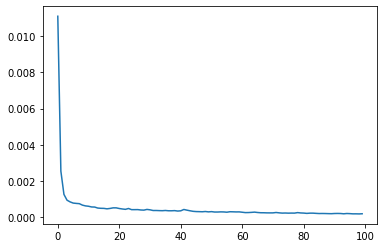

In [ ]:

#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)



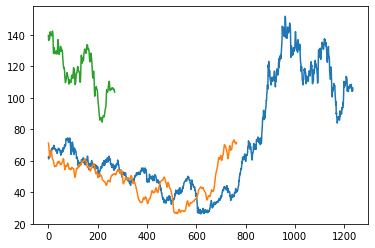

In [ ]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

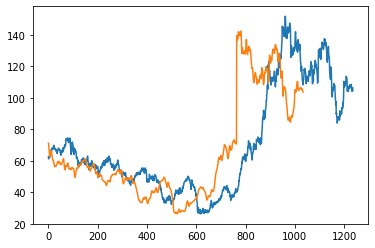

In [ ]:
type(train_predict)
test = np.vstack((train_predict,test_predict))

#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]
fut_inp = fut_inp.reshape(1,-1)

tmp_inp = list(fut_inp)
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.4944150447845459], [0.4902395009994507], [0.48605114221572876], [0.48184800148010254], [0.47763028740882874], [0.4733986556529999], [0.46915510296821594], [0.46490150690078735], [0.46064019203186035], [0.45637333393096924], [0.4521023631095886], [0.4478285610675812], [0.4435526430606842], [0.439275324344635], [0.43499594926834106], [0.43071457743644714], [0.4264306128025055], [0.4221435785293579], [0.41785308718681335], [0.4135586619377136], [0.40925997495651245], [0.4049569070339203], [0.4006495475769043], [0.3963381350040436], [0.3920227587223053], [0.38770395517349243], [0.38338202238082886], [0.379057377576828], [0.3747307360172272], [0.37040218710899353]]


In [ ]:
len(ds_scaled)

1236

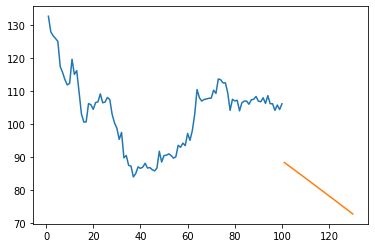

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1136:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()

len(ds_new)

1236

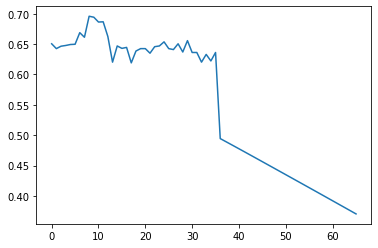

In [ ]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

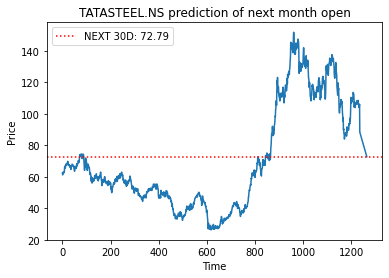

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()